In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import networkx as nx
import seaborn as sns
from matplotlib.gridspec import GridSpec

from paths import PROJECT_ROOT
plots_dir = os.path.join(PROJECT_ROOT, "plots")

sns.set_theme(style="whitegrid", font_scale=1.4)

# Panel A

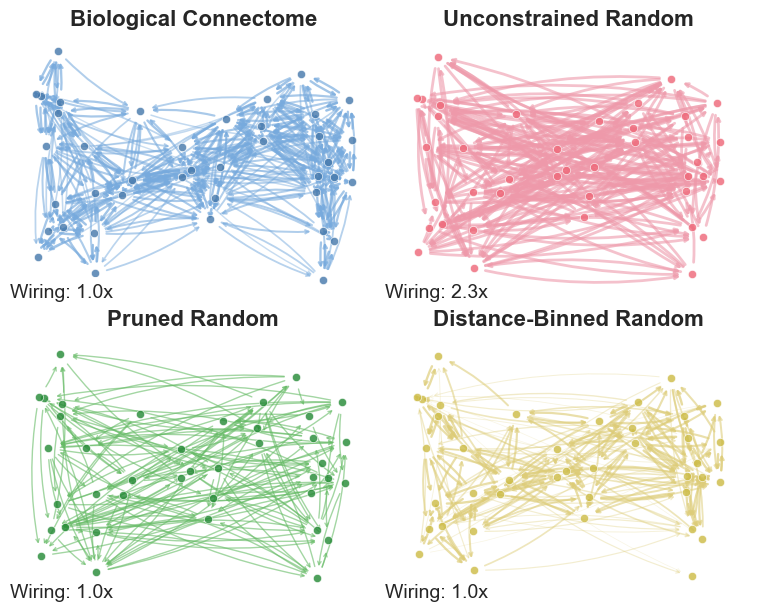

In [2]:
# Set up the figure with Nature-compatible settings
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5

# Create figure
fig1, axs = plt.subplots(2, 2, figsize=(7.5, 6), constrained_layout=True)
axs = axs.flatten()

# Set a seed for reproducibility
np.random.seed(42)

# Generate 3D coordinates for neurons - fixed to exactly n_nodes
n_nodes = 40
nodes_2d = np.zeros((n_nodes, 2))

# Create clusters of nodes
cluster_centers = [
    [0, 0],  # center
    [-1.5, 1],  # top left
    [1.5, 1],  # top right
    [-1.5, -1],  # bottom left
    [1.5, -1],  # bottom right
]

# Assign nodes to clusters with jitter
nodes_per_cluster = n_nodes // len(cluster_centers)
for i, center in enumerate(cluster_centers):
    start_idx = i * nodes_per_cluster
    end_idx = start_idx + nodes_per_cluster if i < len(cluster_centers) - 1 else n_nodes

    for j in range(start_idx, end_idx):
        # Add position with random jitter
        nodes_2d[j, 0] = center[0] + np.random.normal(0, 0.5)
        nodes_2d[j, 1] = center[1] + np.random.normal(0, 0.5)

# Create fake 3D positions (only needed for distance calculations)
nodes_3d = np.column_stack((nodes_2d, np.zeros(n_nodes)))

# Transform 3D to 2D coordinates for visualization
nodes_2d = nodes_3d[:, :2]

# Create a distance matrix
dist_matrix = np.zeros((n_nodes, n_nodes))
for i in range(n_nodes):
    for j in range(n_nodes):
        dist_matrix[i, j] = np.sqrt(np.sum((nodes_3d[i] - nodes_3d[j]) ** 2))

# Normalize distances
max_dist = np.max(dist_matrix)
norm_dist_matrix = dist_matrix / max_dist

# Define edge densities and colors with explicit wiring lengths
configs = [
    {
        "title": "Biological Connectome",
        "density": 0.1,
        "node_color": "#4477AA",
        "edge_color": "#77AADD",
        "rel_length": 1.0,
        "prefers_short": True,
    },
    {
        "title": "Unconstrained Random",
        "density": 0.15,
        "node_color": "#EE6677",
        "edge_color": "#EE99AA",
        "rel_length": 2.3,
        "prefers_short": False,
    },
    {
        "title": "Pruned Random",
        "density": 0.1,
        "node_color": "#228833",
        "edge_color": "#66BB66",
        "rel_length": 1.0,
        "prefers_short": False,
    },
    {
        "title": "Distance-Binned Random",
        "density": 0.1,
        "node_color": "#CCBB44",
        "edge_color": "#DDCC77",
        "rel_length": 1.0,
        "prefers_short": True,
    },
]

# Generate the graphs for each configuration
for idx, config in enumerate(configs):
    # Create a new graph
    G = nx.DiGraph()

    # Add nodes
    for i in range(n_nodes):
        G.add_node(i, pos=nodes_2d[i])

    # Create edges based on configuration
    edges_to_add = []

    if config["title"] == "Biological Connectome":
        # Much stronger preference for short connections
        distance_threshold = 0.6  # Only allow connections below this normalized distance
        
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and norm_dist_matrix[i, j] < distance_threshold:
                    # Higher probability for shorter connections
                    p_connect = (1 - norm_dist_matrix[i, j]/distance_threshold)**2 * config["density"] * 15
                    if np.random.random() < p_connect:
                        weight = 1.0  # Consistent weight
                        edges_to_add.append((i, j, {'weight': weight, 'distance': dist_matrix[i, j]}))
    
    elif config["title"] == "Unconstrained Random":
        # Random connections regardless of distance
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and np.random.random() < config["density"]:
                    weight = np.random.uniform(0.5, 1)
                    edges_to_add.append(
                        (i, j, {"weight": weight, "distance": dist_matrix[i, j]})
                    )

    elif config["title"] == "Pruned Random":
        # Random connections regardless of distance
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and np.random.random() < config["density"]:
                    weight = np.random.uniform(0.2, 0.7)
                    edges_to_add.append(
                        (i, j, {"weight": weight, "distance": dist_matrix[i, j]})
                    )

    elif config["title"] == "Distance-Binned Random":
        # Divide distances into bins and randomize within each bin
        dist_bins = [
            0,
            0.3,
            0.6,
            1.0,
        ]  # Three distance bins with emphasis on shorter connections
        bin_densities = [0.3, 0.1, 0.05]  # Higher density for shorter connections

        for bin_idx in range(len(dist_bins) - 1):
            bin_min, bin_max = dist_bins[bin_idx], dist_bins[bin_idx + 1]
            bin_density = bin_densities[bin_idx]

            # Find node pairs in this distance bin
            bin_pairs = []
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i != j and bin_min <= norm_dist_matrix[i, j] < bin_max:
                        bin_pairs.append((i, j))

            # Randomly select pairs from this bin
            np.random.shuffle(bin_pairs)
            bin_edges_count = int(len(bin_pairs) * bin_density)

            for i, j in bin_pairs[:bin_edges_count]:
                weight = np.random.uniform(0.5, 1.0)
                edges_to_add.append(
                    (i, j, {"weight": weight, "distance": dist_matrix[i, j]})
                )

    # Add the edges to the graph
    for u, v, data in edges_to_add:
        G.add_edge(u, v, **data)

    # Get positions and draw
    pos = nx.get_node_attributes(G, "pos")

    # Calculate node sizes based on degree
    node_sizes = [20 + 3 * G.degree(n) for n in G.nodes()]

    
    
    # Draw the nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        ax=axs[idx],
        node_size=35,
        node_color=config["node_color"],
        alpha=0.8,
        edgecolors="white",
        linewidths=0.5,
    )

    # Draw edges with color and width encoding distance
    # Short connections: thicker and more opaque
    # Long connections: thinner and more transparent
    for u, v, data in G.edges(data=True):
        distance = data["distance"] / max_dist

        # Determine edge properties based on distance
        if config["prefers_short"]:
            # For configurations that prefer short connections
            width = max(0.5, 2.0 * (1.0 - distance))
            alpha = max(0.2, 0.8 * (1.0 - distance))
        else:
            # For configurations that don't differentiate by distance
            width = 1.0
            alpha = 0.6

        nx.draw_networkx_edges(
            G,
            pos,
            ax=axs[idx],
            edgelist=[(u, v)],
            width=width * 2 if config["title"] == "Unconstrained Random" else width,
            alpha=alpha,
            edge_color=config["edge_color"],
            arrows=True,
            arrowsize=6,
            arrowstyle="->",
            connectionstyle="arc3,rad=0.1",
        )

    # Add title and wiring info
    axs[idx].set_title(config["title"], fontsize=16, fontweight="bold")
    axs[idx].text(
        0.,
        0.,
        f"Wiring: {config['rel_length']:.1f}x",
        transform=axs[idx].transAxes,
        fontsize=14,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
    )

    # Remove axes
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].spines["top"].set_visible(False)
    axs[idx].spines["right"].set_visible(False)
    axs[idx].spines["bottom"].set_visible(False)
    axs[idx].spines["left"].set_visible(False)

# plt.suptitle("Network Configuration Comparison", fontsize=10, fontweight="bold")
plt.savefig(os.path.join(plots_dir, "figure2a_network_configs.png"), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(plots_dir, "figure2a_network_configs.pdf"), bbox_inches="tight")
plt.show()

# Panel b

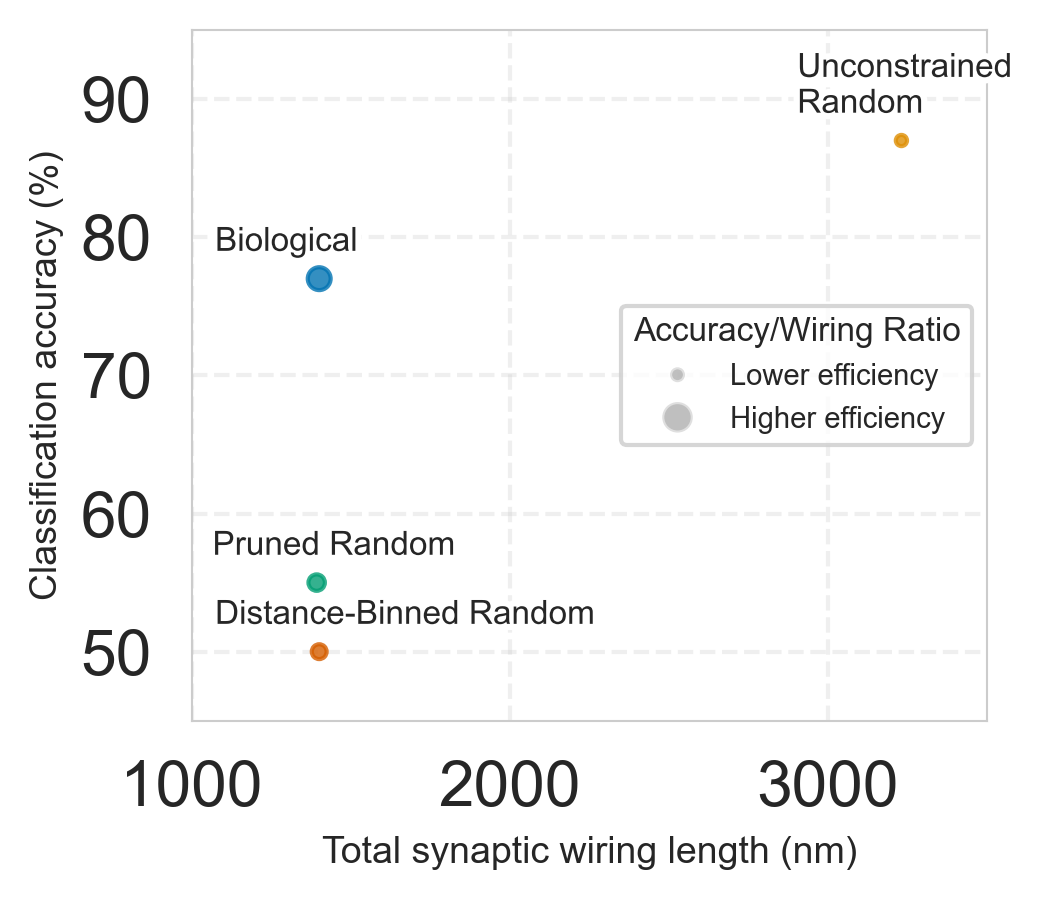

In [3]:
# Data from Table 4.2 in your manuscript
networks = [
    "Biological",
    "Unconstrained\nRandom",
    "Pruned Random",
    "Distance-Binned Random",
]
wiring_length = [1401, 3231, 1393, 1401]  # Total synaptic length (mm)
accuracy = [77, 87, 55, 50]  # Mean accuracy (%)
neurons_activated = [57, 75, 75, 57]  # Percentage of neurons activated

# Calculate efficiency (accuracy per unit wiring)
efficiency = [acc / length * 100 for acc, length in zip(accuracy, wiring_length)]

# Colors that work well for Nature (colorblind-friendly, print-friendly)
colors = ["#0173B2", "#DE8F05", "#029E73", "#D55E00"]

# Create the figure with Nature-compatible dimensions
fig2, ax = plt.subplots(figsize=(3.5, 3.2), dpi=300)  # Nature's single column width

# Create scatter plot with varying point sizes based on efficiency
sizes = [e ** 2 for e in efficiency]  # Scale efficiency for better visualization
scatter = ax.scatter(wiring_length, accuracy, s=sizes, c=colors, alpha=0.8, zorder=3)

"""# Connect points with a line to show the trade-off
# Only connect biological to unconstrained random to show the main comparison
ax.plot(
    [wiring_length[0], wiring_length[1]],
    [accuracy[0], accuracy[1]],
    "k--",
    alpha=0.3,
    zorder=1,
)"""

# Add labels with a white outline for better visibility
for i, txt in enumerate(networks):
    text = ax.annotate(
        txt,
        (wiring_length[i], accuracy[i]),
        fontsize=8,
        ha="left",
        va="bottom",
        xytext=(-25, 5),
        textcoords="offset points",
    )
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="white")])

# Add x and y-axis labels with units
ax.set_xlabel("Total synaptic wiring length (nm)", fontsize=9)
ax.set_ylabel("Classification accuracy (%)", fontsize=9)

# Set axis limits with some padding
ax.set_xlim(1000, 3500)
ax.set_ylim(45, 95)

# Add grid for readability (light grid typical for Nature figures)
ax.grid(linestyle="--", alpha=0.3, zorder=0)


# Create legend for the point sizes representing efficiency
# Create custom handles for legend
class SizedPatchHandler(HandlerPatch):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        size = orig_handle.get_width()
        p = mpatches.Circle(
            (0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            size / 3,
            edgecolor=orig_handle.get_edgecolor(),
            facecolor=orig_handle.get_facecolor(),
            transform=trans,
        )
        return [p]


# Create legend handles
efficiency_levels = [min(efficiency), max(efficiency)]
legend_sizes = [e * 2 for e in efficiency_levels]
legend_labels = [f"{e:.1f}" for e in efficiency_levels]

handles = [
    mpatches.Rectangle(
        (0, 0), legend_sizes[0], legend_sizes[0], facecolor="gray", alpha=0.5
    ),
    mpatches.Rectangle(
        (0, 0), legend_sizes[1], legend_sizes[1], facecolor="gray", alpha=0.5
    ),
]

# Add legend with custom handler
ax.legend(
    handles,
    [f"Lower efficiency", f"Higher efficiency"],
    title="Accuracy/Wiring Ratio",
    handler_map={mpatches.Rectangle: SizedPatchHandler()},
    loc="center right",
    fontsize=7,
    title_fontsize=8,
)

# Adjust layout and save
plt.tight_layout()
fig2.subplots_adjust(right=0.98, top=0.95)

# Save figure with transparent background (Nature preference)
plt.savefig(os.path.join(plots_dir,"figure2_panel_b.png"), dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(os.path.join(plots_dir,"figure2_panel_b.pdf"), bbox_inches="tight") 
plt.show()

# Pancel c

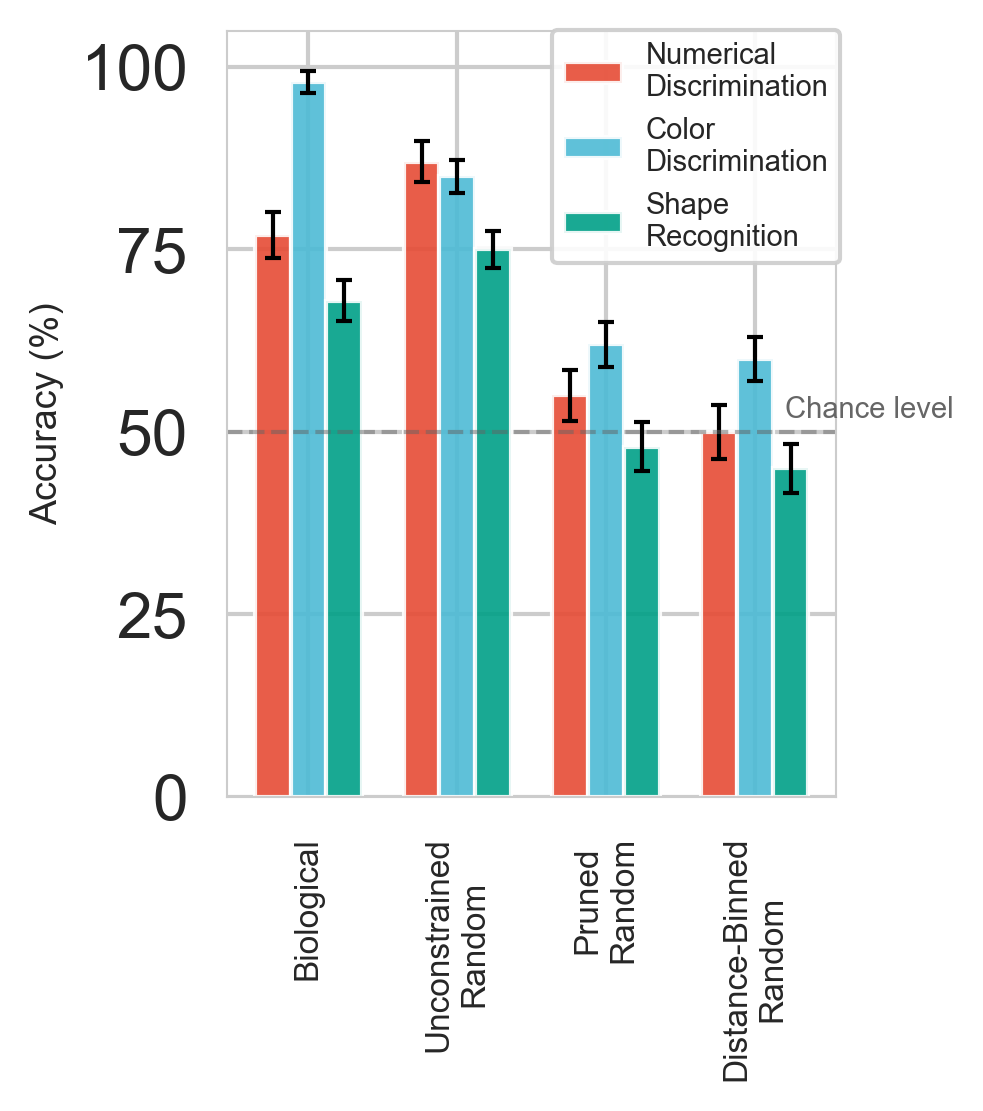

In [4]:
# Network configurations
networks = [
    "Biological",
    "Unconstrained\nRandom",
    "Pruned\nRandom",
    "Distance-Binned\nRandom",
]

# Made-up performance data for three tasks (percentage accuracy)
numerical_task = [77, 87, 55, 50]  # From your Table 4.2
color_task = [98, 85, 62, 60]  # Made up - biological better for color
shape_task = [68, 75, 48, 45]  # Made up - unconstrained better for shapes

# Made-up error bars (standard error)
numerical_err = [3.2, 2.8, 3.5, 3.7]
color_err = [1.5, 2.2, 3.1, 3.0]
shape_err = [2.8, 2.5, 3.3, 3.4]

# Nature color palette (starts with red and blue)
colors = ["#E64B35", "#4DBBD5", "#00A087"]

# Set width of bars
bar_width = 0.24
capsize = 2
index = np.arange(len(networks))

# Create the figure with Nature-compatible dimensions
fig3, ax = plt.subplots(
    figsize=(3.5, 3.5), dpi=300
)  # Slightly taller to accommodate vertical labels

# Create grouped bars in the requested order with error bars
bars1 = ax.bar(
    index - bar_width,
    numerical_task,
    bar_width,
    yerr=numerical_err,
    label="Numerical\nDiscrimination",
    color=colors[0],
    alpha=0.9,
    capsize=capsize,
    ecolor="black",
    error_kw={"elinewidth": 1},
)
bars2 = ax.bar(
    index,
    color_task,
    bar_width,
    yerr=color_err,
    label="Color\nDiscrimination",
    color=colors[1],
    alpha=0.9,
    capsize=capsize,
    ecolor="black",
    error_kw={"elinewidth": 1},
)
bars3 = ax.bar(
    index + bar_width,
    shape_task,
    bar_width,
    yerr=shape_err,
    label="Shape\nRecognition",
    color=colors[2],
    alpha=0.9,
    capsize=capsize,
    ecolor="black",
    error_kw={"elinewidth": 1},
)

# Add horizontal line for chance level (50% for binary classification)
ax.axhline(y=50, linestyle="--", color="#666666", alpha=0.5, linewidth=1)

# Add text label for chance level
ax.text(len(networks) - 0.8, 52, "Chance level", fontsize=7, color="#666666")

# Add labels and custom x-axis tick labels
ax.set_ylabel("Accuracy (%)", fontsize=9)
ax.set_ylim(0, 105)  # Slightly higher to accommodate error bars
ax.set_xticks(index)
ax.set_xticklabels(networks, fontsize=8, rotation=90)  # Vertical labels

# Add a legend
ax.legend(bbox_to_anchor=(1.03, 1.02), fontsize=7, loc="upper right", framealpha=0.9)

# No grid lines as requested
"""
# Add panel label (c) in the Nature style
ax.text(
    -0.15, 1.05, "c", transform=ax.transAxes, fontsize=12, fontweight="bold", va="top"
)
"""
# Adjust layout with extra bottom margin for vertical labels
plt.tight_layout()
fig3.subplots_adjust(bottom=0.2)  # Make room for vertical labels

# Save figure with transparent background (Nature preference)
plt.savefig(os.path.join(plots_dir, "figure2_panel_c.png"), dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(os.path.join(plots_dir, "figure2_panel_c.pdf"), bbox_inches="tight") 
plt.show()

# Panel d

Changed working directory to /home/eudald/Desktop/doctorat/connectome
Project root: /home/eudald/Desktop/doctorat/connectome


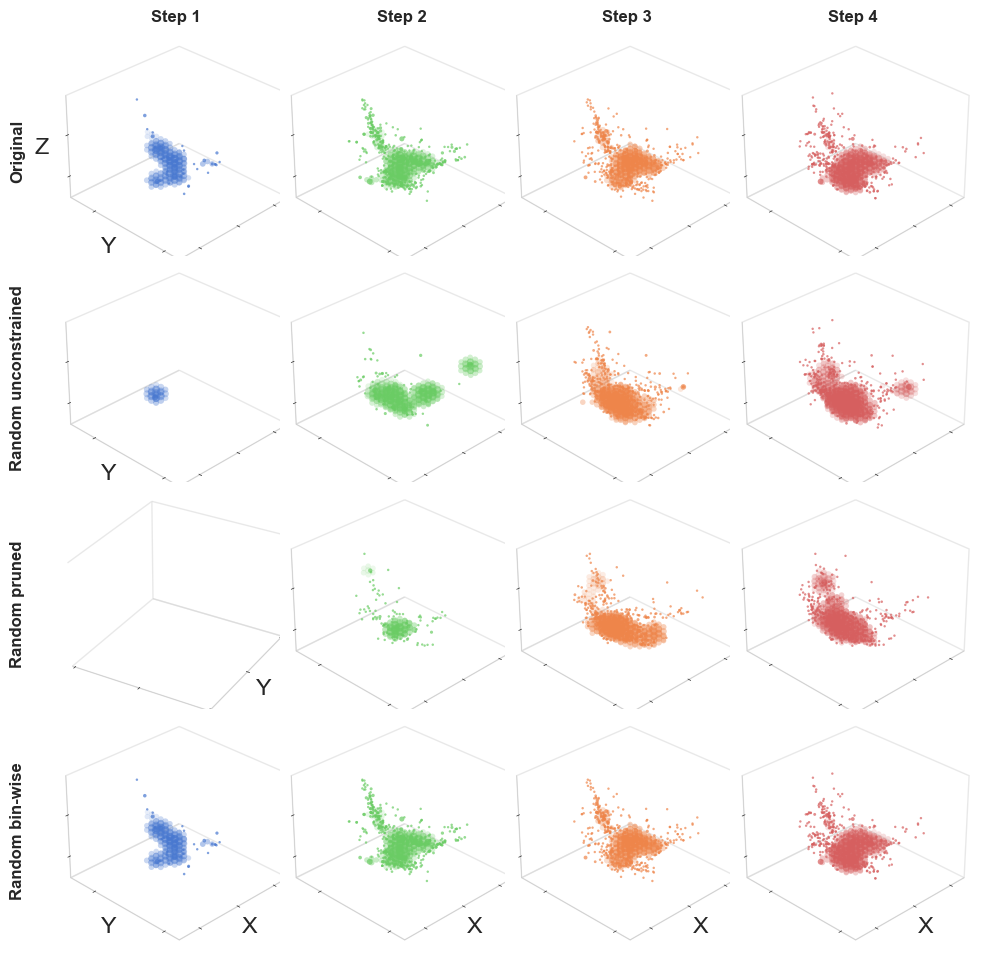

In [5]:
from notebooks.visualization.activation_plots import visualize_steps_separated_compact
from notebooks.visualization.random_activations_funcs import get_activation_dictionnary, load_neuron_position_data


configurations = get_activation_dictionnary()
neuron_position_data = load_neuron_position_data()

fig4 = visualize_steps_separated_compact(
    configurations,
    neuron_position_data,
    max_neurons_per_step=500,
    voxel_size=25,
    smoothing=1.2,
    padding_percent=15,
)

# Save figure with transparent background (Nature preference)
plt.savefig(os.path.join(plots_dir, "figure2_panel_d.png"), dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(os.path.join(plots_dir, "figure2_panel_d.pdf"), bbox_inches="tight") 
plt.show()

# All together

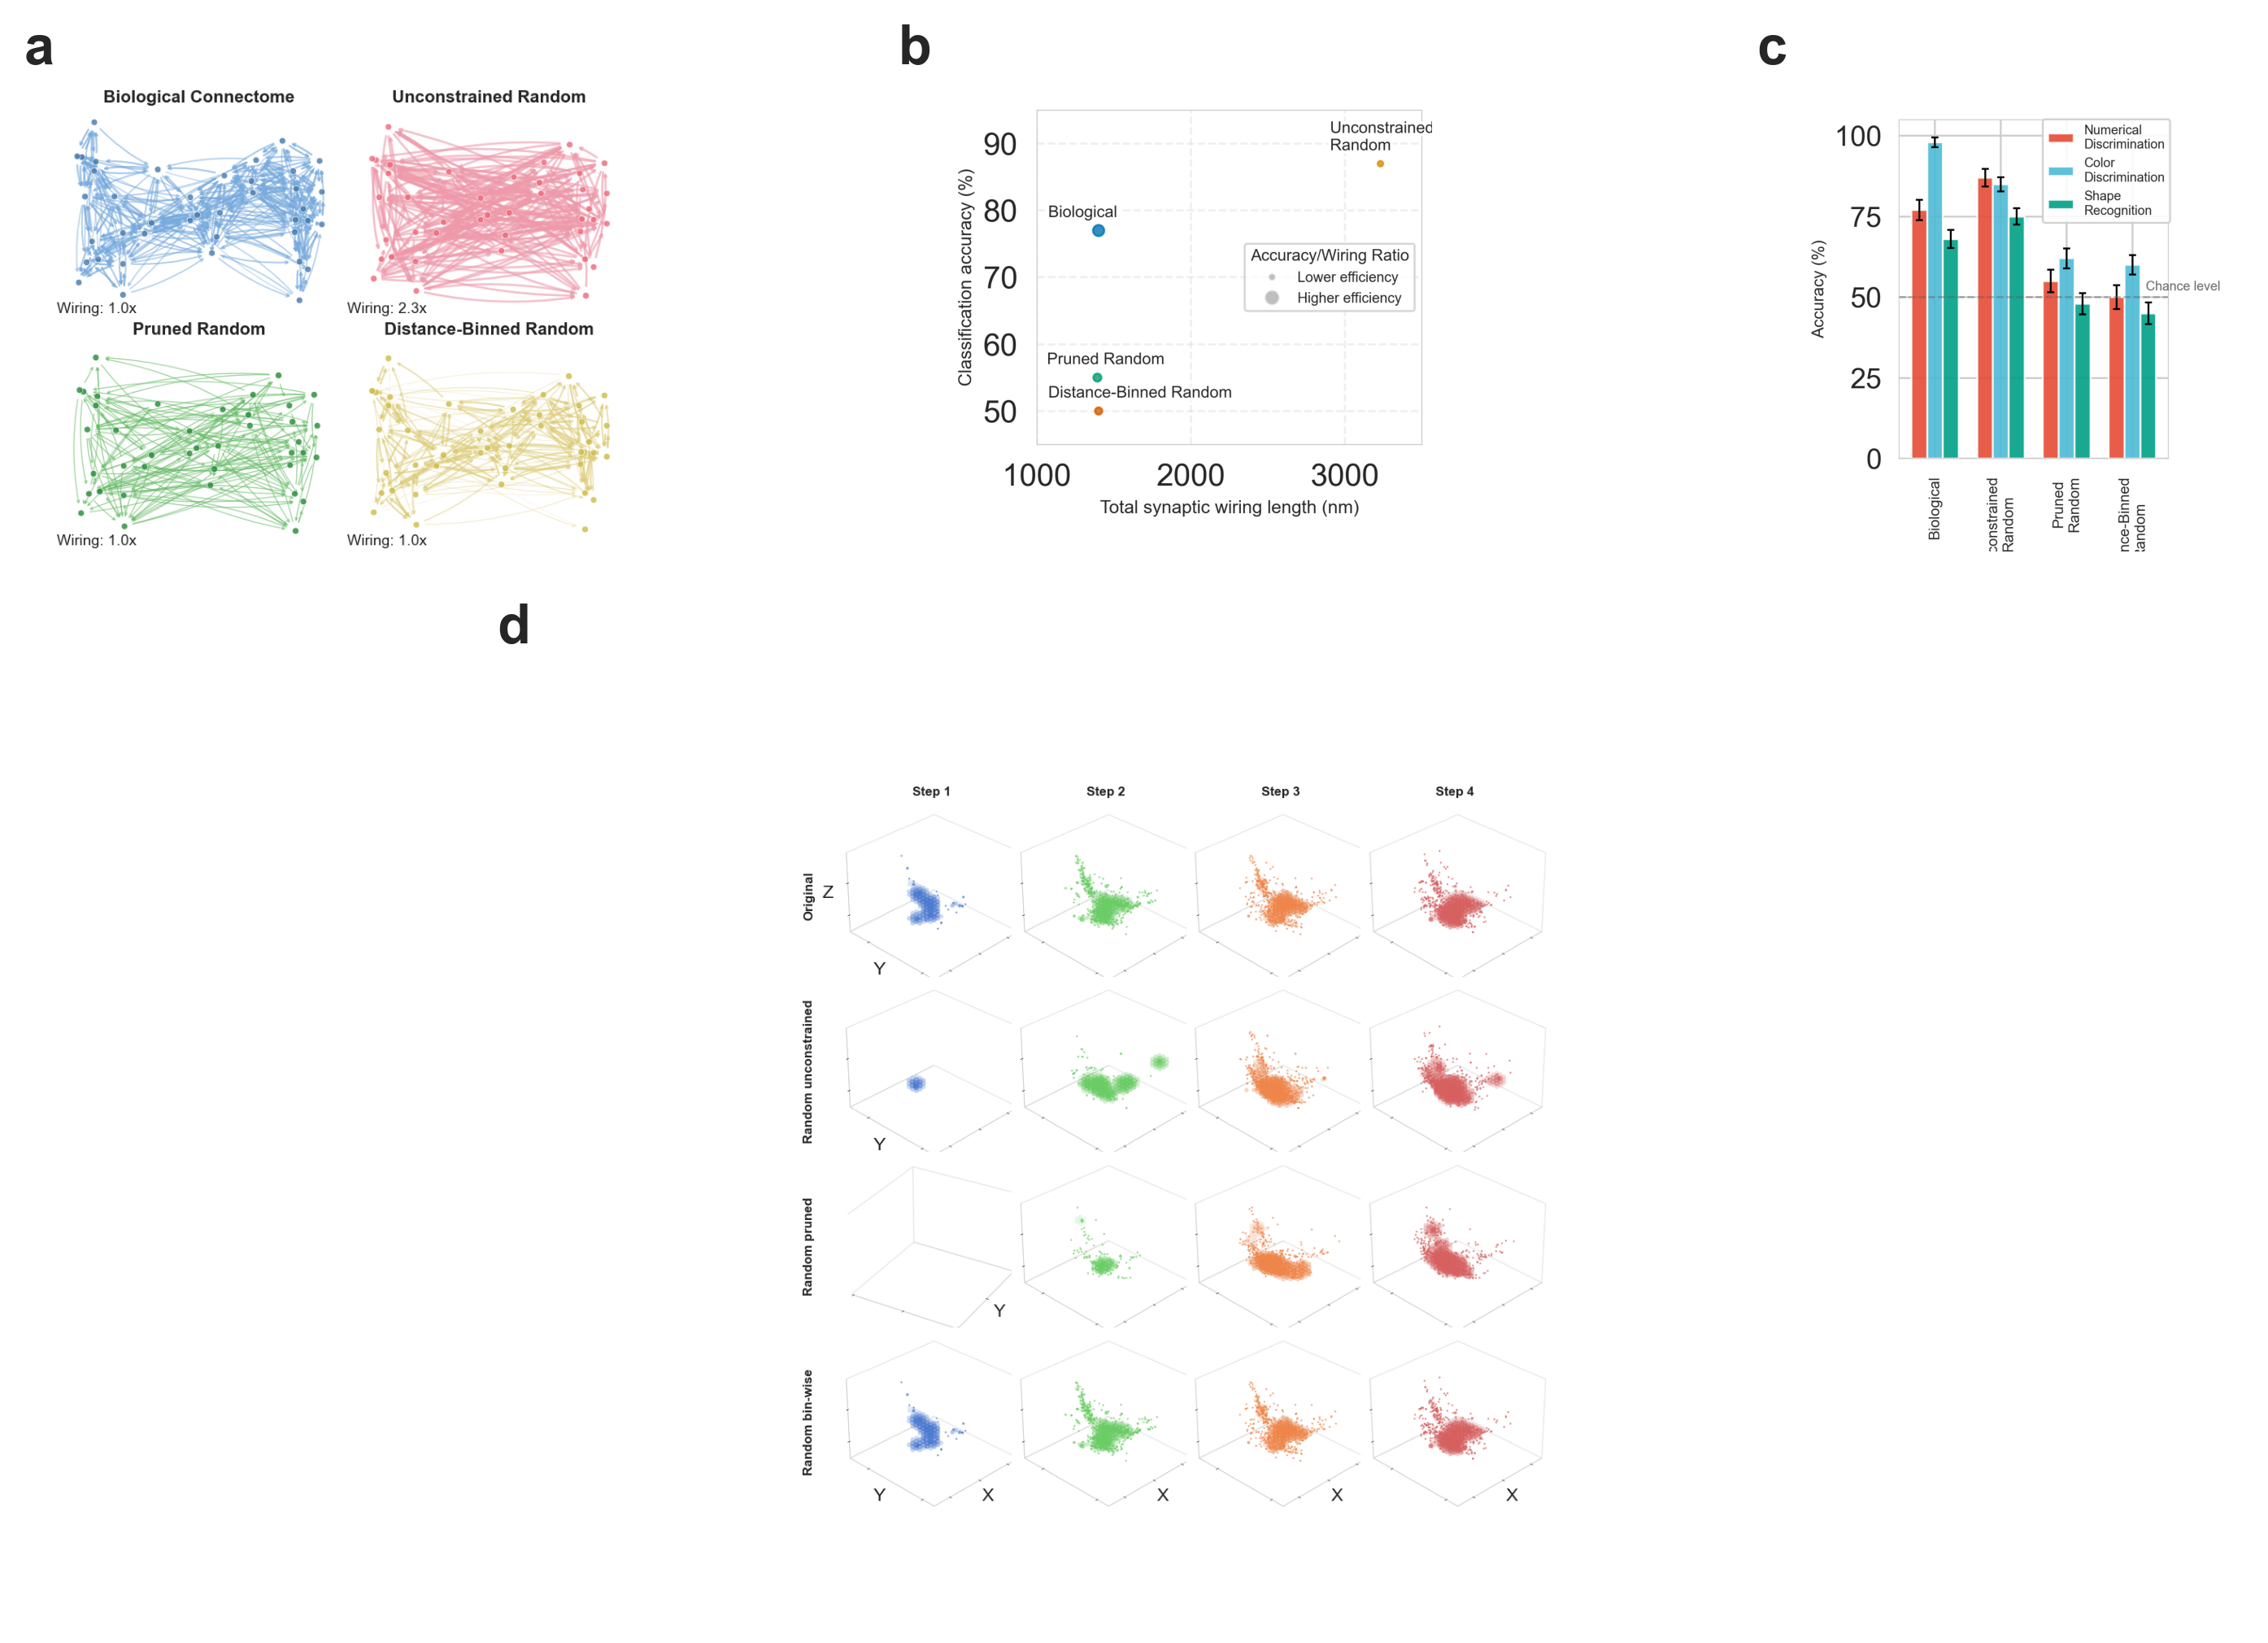

In [6]:
# Create a new composite figure
fig = plt.figure(
    figsize=(10.5, 7.0), dpi=300
)  # Wider figure to accommodate 3 plots in top row

# Create a custom grid - 2 rows, 3 columns
# First row will have 3 equal plots (a, b, c)
# Second row will have 1 plot (d) spanning all 3 columns
gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 2])  # Make bottom row twice as tall


# Function to transfer content from one figure to a subplot in another figure
def transfer_figure_to_axes(source_fig, target_axes):
    # Get the renderer from the source figure
    canvas = source_fig.canvas
    if canvas is None:
        canvas = FigureCanvas(source_fig)

    # Convert the source figure to an image
    source_fig.canvas.draw()
    image = np.array(source_fig.canvas.renderer.buffer_rgba())

    # Display the image in the target axes
    target_axes.imshow(image)
    target_axes.axis("off")


# Create subplots for a, b, c in top row
ax1 = fig.add_subplot(gs[0, 0])  # Plot a - top left
ax2 = fig.add_subplot(gs[0, 1])  # Plot b - top middle
ax3 = fig.add_subplot(gs[0, 2])  # Plot c - top right

# Create subplot for d spanning the entire bottom row
ax4 = fig.add_subplot(gs[1, :])  # Plot d - entire bottom row

# Transfer each figure to its respective subplot
transfer_figure_to_axes(fig1, ax1)
transfer_figure_to_axes(fig2, ax2)
transfer_figure_to_axes(fig3, ax3)
transfer_figure_to_axes(fig4, ax4)

# Add panel labels
x_off = -0.05
y_off = 1.05
ax1.text(x_off, y_off, "a", transform=ax1.transAxes, fontsize=16, fontweight="bold")
ax2.text(x_off, y_off, "b", transform=ax2.transAxes, fontsize=16, fontweight="bold")
ax3.text(x_off, y_off, "c", transform=ax3.transAxes, fontsize=16, fontweight="bold")
ax4.text(x_off, y_off, "d", transform=ax4.transAxes, fontsize=16, fontweight="bold")

plt.tight_layout()
plt.savefig(
    os.path.join(plots_dir, "network_configs_panel.png"), dpi=300, bbox_inches="tight"
)
plt.savefig(os.path.join(plots_dir, "network_configs_panel.pdf"), bbox_inches="tight")
plt.show()

In [7]:
configurations["Random pruned"]

,root_id,input,activation_1,activation_2,activation_3,activation_4
0,720575940615280638,0.000000,0.0,0.000000,2.928968,243.417827
1,720575940629819095,0.000000,0.0,0.000000,3.951390,-554.564496
2,720575940614814383,0.000000,0.0,0.000000,-0.415012,-771.899094
3,720575940633358796,0.000000,0.0,0.000000,0.000000,0.000000
4,720575940619921172,0.125025,0.0,0.000000,0.174971,185.015735
...,...,...,...,...,...,...
3072,720575940608239026,0.000000,0.0,0.000000,-4.268392,983.887970
3073,720575940625986087,0.000000,0.0,0.000000,4.271744,2345.648395
3074,720575940625494164,0.000000,0.0,0.000000,-0.444434,-195.034416
3075,720575940619775355,0.000000,0.0,0.723367,4.946246,932.203817


In [9]:
configurations["Random unconstrained"]

,root_id,input,activation_1,activation_2,activation_3,activation_4
0,720575940615280638,0.000000,0.0,0.0,164.144807,560354.939141
1,720575940629819095,0.000000,0.0,0.0,0.000000,19885.501953
2,720575940614814383,0.000000,0.0,0.0,230.258762,730288.380241
3,720575940633358796,0.000000,0.0,0.0,247.873066,159221.282618
4,720575940619921172,0.125025,0.0,0.0,0.000000,1634.019557
...,...,...,...,...,...,...
3072,720575940608239026,0.000000,0.0,0.0,0.000000,0.000000
3073,720575940625986087,0.000000,0.0,0.0,104.164146,307279.750467
3074,720575940625494164,0.000000,0.0,0.0,8.663989,83188.956900
3075,720575940619775355,0.000000,0.0,0.0,14.508219,36140.451205


In [10]:
aa = get_activation_dictionnary()

In [11]:
aa["Random pruned"]

,root_id,input,activation_1,activation_2,activation_3,activation_4
0,720575940615280638,0.0,0.0,0.013682,-11.752952,753.519563
1,720575940629819095,0.0,0.0,0.000000,8.211705,-3421.820676
2,720575940614814383,0.0,0.0,0.000000,9.775571,-546.145246
3,720575940633358796,0.0,0.0,0.000000,0.000000,0.000000
4,720575940619921172,0.0,0.0,0.000000,1.615483,55.876042
...,...,...,...,...,...,...
3072,720575940608239026,0.0,0.0,0.000000,8.203334,-1166.900383
3073,720575940625986087,0.0,0.0,0.000000,-43.942820,-2131.087986
3074,720575940625494164,0.0,0.0,0.000000,-0.413842,-169.438264
3075,720575940619775355,0.0,0.0,0.062745,1.428127,-2735.014326
